# Group 10 - First Year Project
### Data Science at ITU 
## Project 2 - Correlation between Covid-19's spread and weather conditions

Introduction

This notebook contains all the code developed in the Project 2 - Correlation between Covid-19's spread and weather conditions

Contact/Group: 
- Florian Micliuc(flmi@itu.dk)
- Louis Caspar Brandt (locb@itu.dk) (see disclosure statement in the report)
- Iben Mai Huse (ibhu@itu.dk)
- Katalin Literati-Dobos (klit@itu.dk)
- Ruben Jonsman (rubj@itu.dk)

# Library imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from folium.features import DivIcon
import imageio
from matplotlib import rcParams
import calplot

# Functions

In [2]:
def check_null_values(file, string):
    if file.isnull().values.any():
        print('There are null values in {} dataset'.format(string))
    else:
        print('There are no null values in {} dataset'.format(string))

In [3]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

In [4]:
def weather_mean_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title('Mean of' + ' '+ column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [5]:
def corona_total_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [6]:
def corona_line_plot(df,x,y,title):
    ax = df.plot.line(x = x, y = y,rot = 45,figsize = (20,6),color = 'silver')
    ax.set_title(title)
    ax.set_ylabel("Covid-19 Cases")
    ax.set_xlabel("Date")
    plt.axvline(x='2020-03-15',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-03-22',color = '#f00008',ls = '--');
    plt.axvline(x='2020-04-15',color = 'blue',ls = '--');
    plt.axvline(x='2020-11-02',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-12-15',color = '#f00008',ls = '--');
    plt.axvline(x='2020-12-26',color = '#00ff68',ls = '--');

In [7]:
def corona_bar_plot(x,y,title):
    fig = plt.figure(figsize=(20,6))
    axes = fig.add_axes([0,0,1,1])
    axes.bar(x, y,color = 'silver',edgecolor = 'black')
    axes.set_title(title)
    axes.set_ylabel("Covid-19 Cases")
    axes.set_xlabel("Date")

In [8]:
def pearson_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [9]:
def spearman_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = spearmanr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [10]:
def pearson_log(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(np.log(df[column]), df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [11]:
def heat_calendar(df,column,color,title):
    calplot.calplot(df[column], cmap=color,colorbar = True,figsize = (16,4),suptitle=title)

# Task 0 - Data cleaning and filtering

## Loading data

The data was loaded by creating a small pipeline to keep track of files and locations, in case they would change. This approach made it easy to change file locations if needed.

In [12]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"
SUBPATH["age"] = "age/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"
FILENAME["age_pop"] = "Altersverteilung_Bevolkerung.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]
age_pop = PATH["data_external"]+SUBPATH["age"]+FILENAME["age_pop"]

The dates is parsed in the data, so that it has a consistent form. The data is tab seperated and thus we load the data with a tab seperator. We also append the extra data that was provided to our original weather data frame.

In [13]:
raw_data = {}

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

#data
raw_data['de_corona'] = pd.read_csv(corona, sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\t', parse_dates=['date'], date_parser=dateparse)
additional = pd.read_csv('../Data/Raw/weather/weather2.csv', sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = raw_data['weather'].append(additional)

#open jsonfile_metadata
with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.loads(f.read())

#task4
raw_data['age_pop'] = pd.read_csv(age_pop, sep=';', decimal=',')

In [14]:
HEADERS = ['de_corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

de_corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (20220, 9)


## Data type insight

With the data provided involved the following fields: 

In [15]:
list(raw_data["weather"].columns), list(raw_data["de_corona"].columns)

(['date',
  'iso3166-2',
  'RelativeHumiditySurface',
  'SolarRadiation',
  'Surfacepressure',
  'TemperatureAboveGround',
  'Totalprecipitation',
  'UVIndex',
  'WindSpeed'],
 ['date', 'region_code', 'confirmed_addition', 'deceased_addition'])

The following fields are categorical variables:
- iso3166-2 (the codes of the regions in Germany)
- date
- region_code (the name of the region)

The following fields are numerical variables:
- RelativeHumiditySurface 
- SolarRadiation (measured j/sqm)
- Surfacepressure 
- TemperatureAboveGround (measured in Kelvin)
- Totalprecipitation
- UVIndex (1-10)
- Windspeed (m/s)
- confirmed_addition (number of confirmed Covid-19 infections)
- deceased_addition (number of deceased with a confirmed Covid-19 infections)

All the weather data is a 24-hour sum of the day, which will result in higher than expected values, these variables can be divided by 24 to get the mean of the day, though this will also be flawed data, since the data will have a daily mean. SolarRadiation, UVIndex is only relevent when the sun is actually present during the day, by getting the daily mean, the hours of the day where the sun is not active is taken into account, which results in lower than expected values. 

## Filtering the weather dataset

Our assigned country in this project is Germany and thus we filter the data so that we only have data from Germany

In [16]:
#get Germany data
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
#reset_index
weather_data_de.reset_index(drop=True, inplace=True)

#Processed data
processed_data = {}
processed_data["weather"] = weather_data_de
processed_data["weather"].to_csv("../Data/Processed/processed_weather.csv")
processed_data["de_corona"] = raw_data["de_corona"]

## Sanity check

Here we check for typical issues with raw data. We are checking for missing data, duplicate data and null values.

### Check for null values

In [17]:
check_null_values(raw_data['de_corona'], "de_corona")
check_null_values(weather_data_de, "weather_data_de")

There are no null values in de_corona dataset
There are no null values in weather_data_de dataset


### Checking if our data source corrected their data by adding negative values to the previous day, to get the cummulitative sum correct

In [18]:
print('min deaths',min(raw_data['de_corona']['deceased_addition']))
print('min cases',min(raw_data['de_corona']['confirmed_addition']))

min deaths 0
min cases 1


### Checking and visualizing for weird values

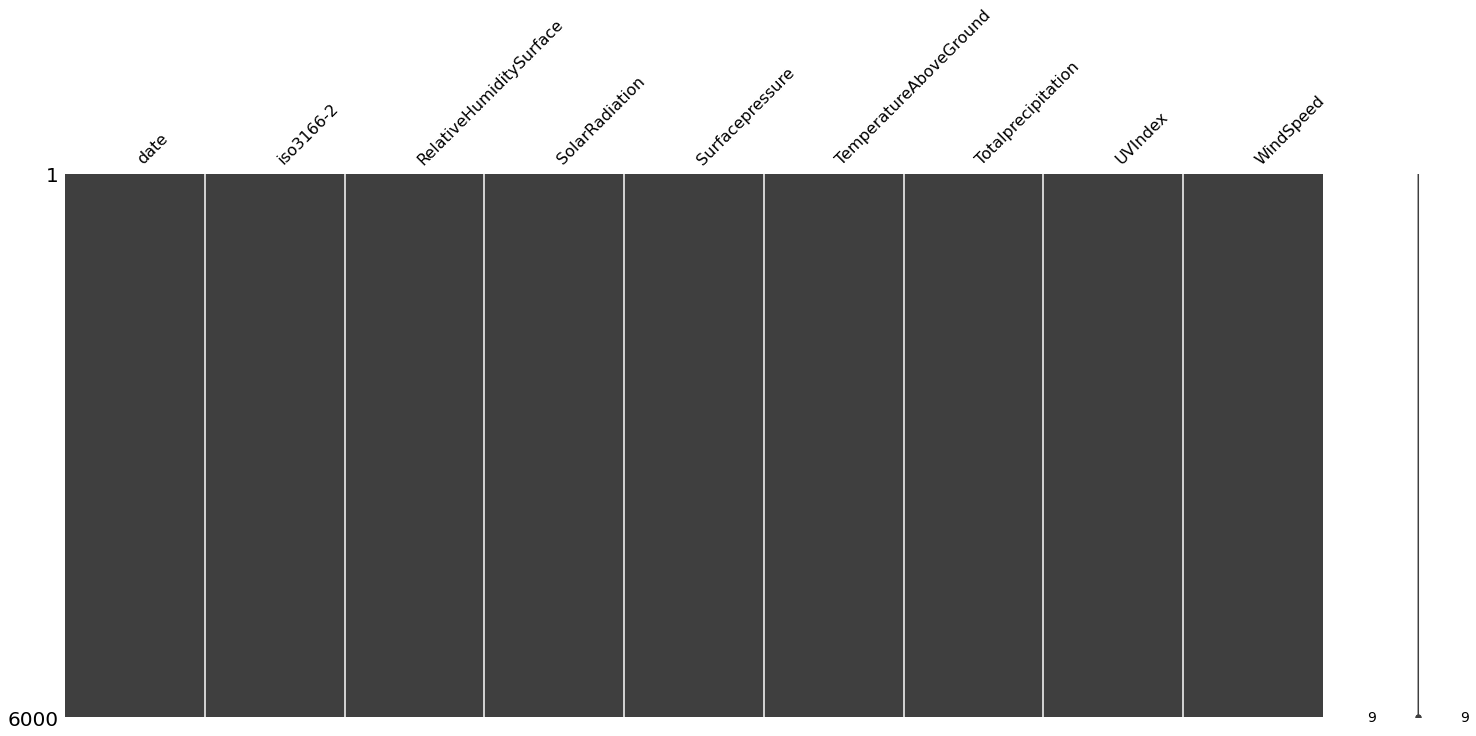

In [19]:
dataset_checker_values(weather_data_de,-999) #-999

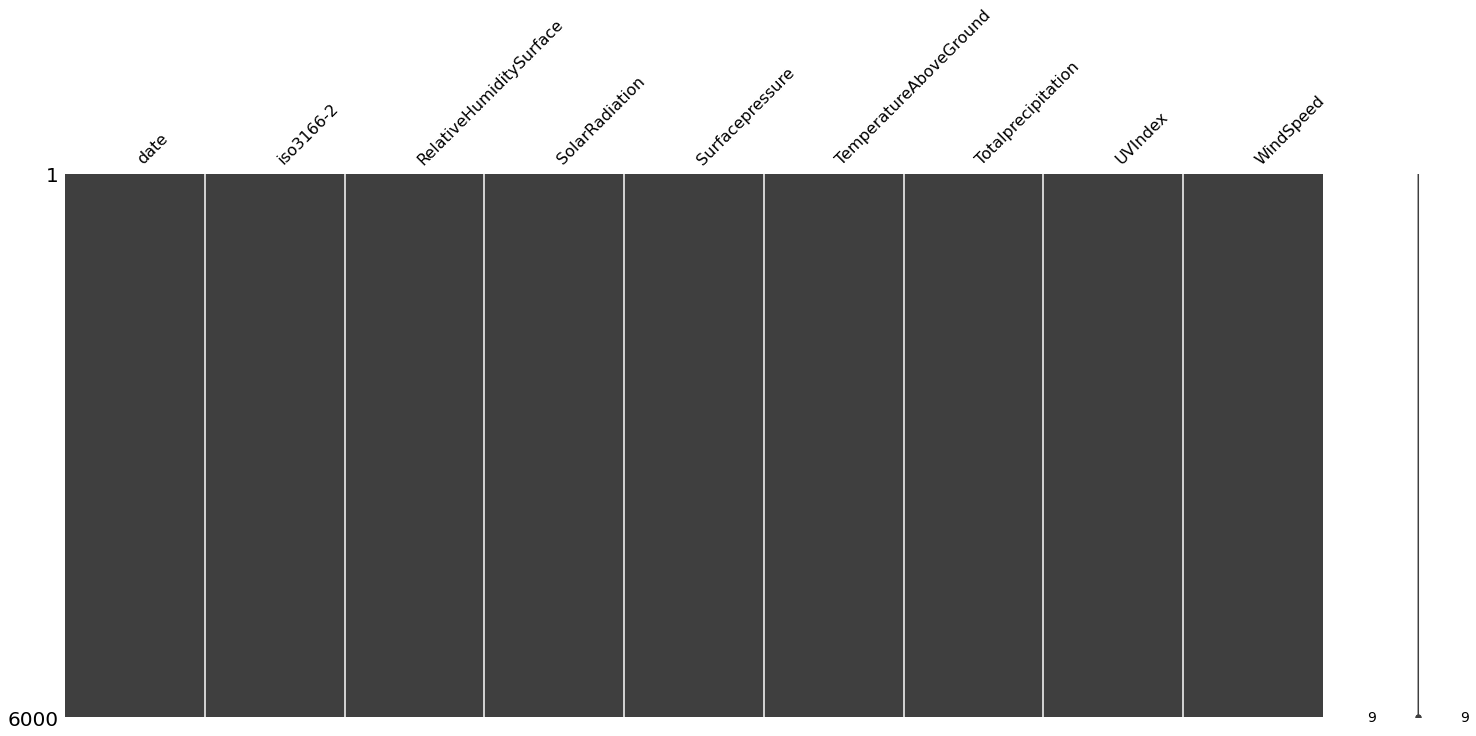

In [20]:
dataset_checker_values(weather_data_de,-1) #-1

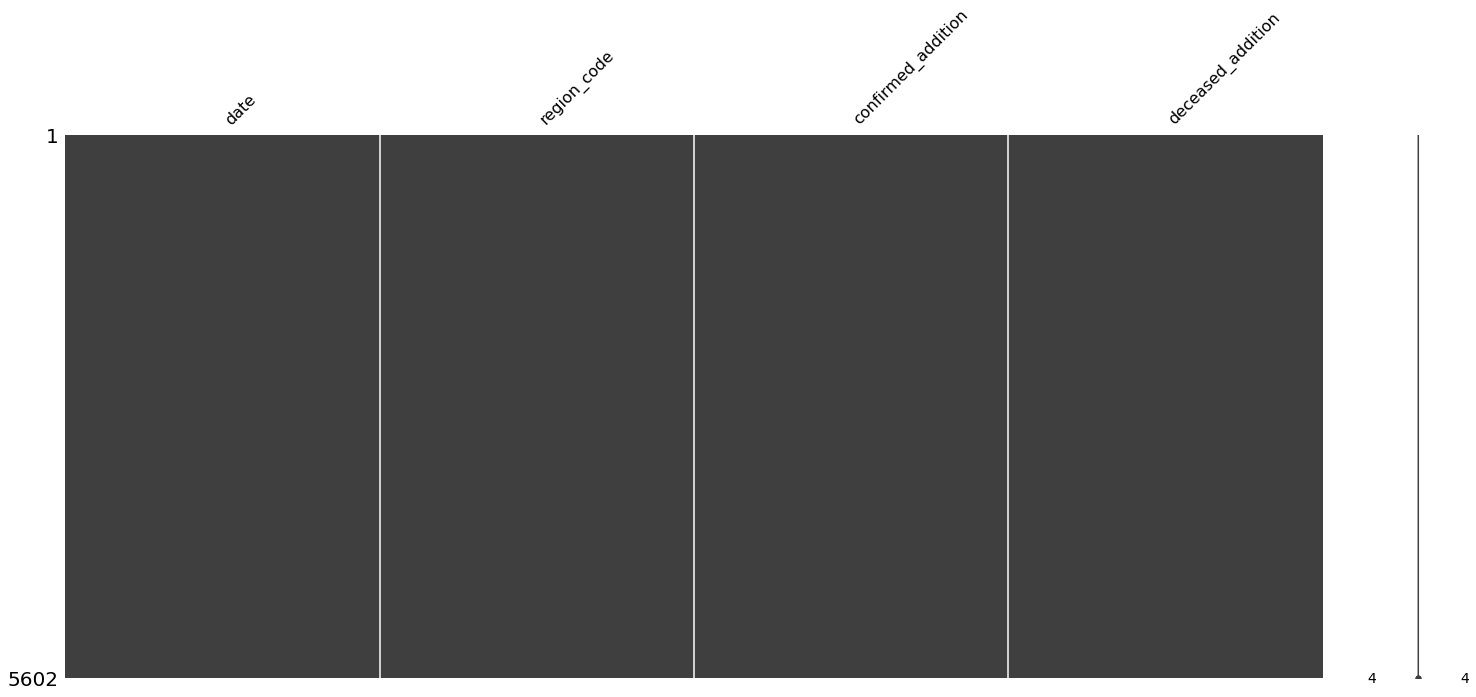

In [21]:
dataset_checker_values(raw_data['de_corona'],-999) #-999

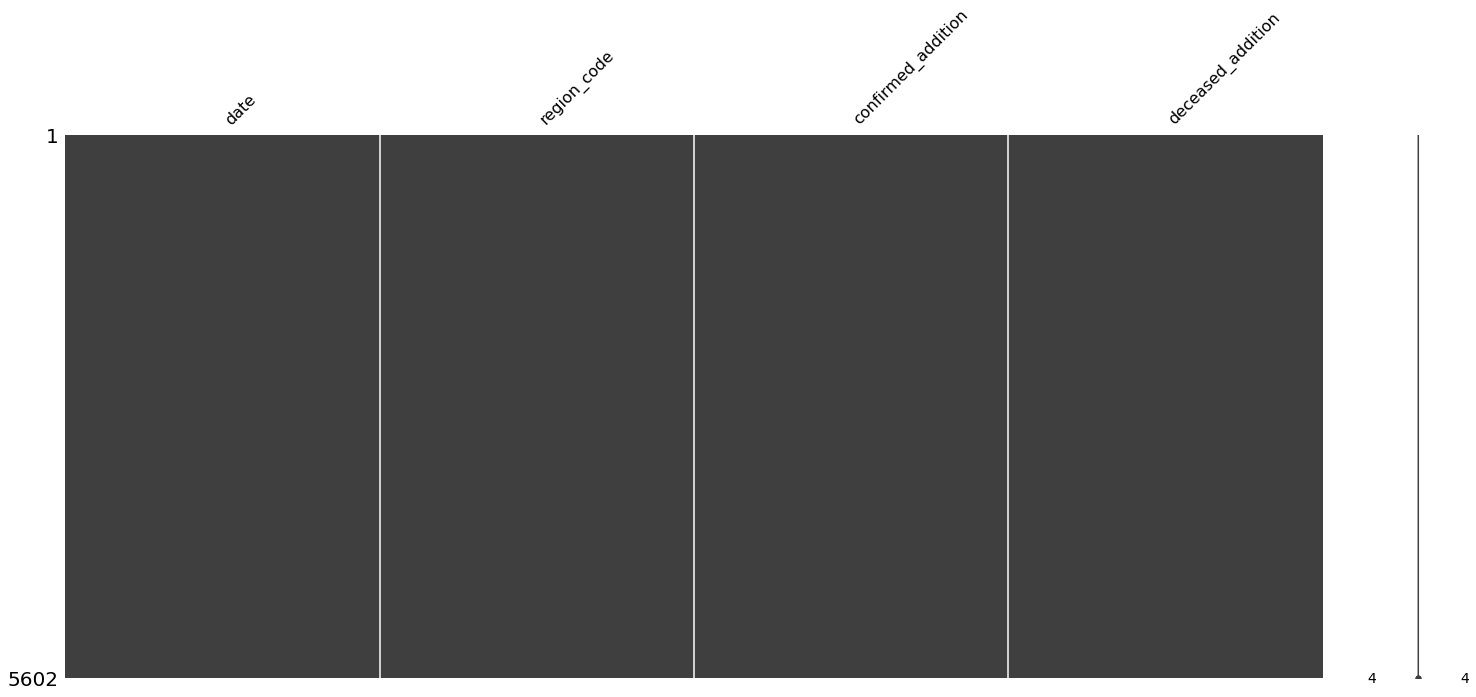

In [22]:
dataset_checker_values(raw_data['de_corona'],-1) #-1

There are no gaps in the plots thus -1 and -999 don't occur in both datasets.

### Checking for duplicates

In [23]:
if True in list(raw_data["de_corona"].duplicated()):
    print("Duplicate rows")
else: 
    print("No duplicate rows")

No duplicate rows


## Data Manipulation

Mapping the region code to the iso3166_2-code

In [24]:
corona_df = raw_data['de_corona']
ss = dict()
for i in country_metadata['country_metadata']:
    ss[i['covid_region_code']] = i['iso3166-2_code']
corona_df['region'] = corona_df['region_code'].map(ss)
corona_df

date          region_code  confirmed_addition  deceased_addition  \
0    2020-01-02  Nordrhein-Westfalen                   1                  0   
1    2020-01-07  Nordrhein-Westfalen                   1                  0   
2    2020-01-09  Nordrhein-Westfalen                   1                  1   
3    2020-01-12  Nordrhein-Westfalen                   1                  0   
4    2020-01-14  Nordrhein-Westfalen                   1                  0   
...         ...                  ...                 ...                ...   
5597 2021-02-21      Rheinland-Pfalz                 120                  0   
5598 2021-02-21              Sachsen                  68                  0   
5599 2021-02-21       Sachsen-Anhalt                  84                  0   
5600 2021-02-21   Schleswig-Holstein                 113                  0   
5601 2021-02-21            Thüringen                 131                  0   

     region  
0     DE-NW  
1     DE-NW  
2     DE-NW  
3     DE-NW  
4     DE-NW  
...     ...  
5597  DE-RP  
5598  DE-SN  
5599  DE-ST  
5600  DE-SH  
5601  DE-TH  

[5602 rows x 5 columns]

In [25]:
celsius = pd.DataFrame(weather_data_de['TemperatureAboveGround'].subtract(273.15))
weather_data_de['Temp_Celsius'] = celsius
weather_data_de


#grouping weather conditions per day
weather_date = pd.to_datetime(weather_data_de['date'])
weather_daily = pd.DataFrame(weather_data_de.groupby(weather_date).mean())
#weather_daily

<ipython-input-25-907ba89523ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_de['Temp_Celsius'] = celsius


In [26]:
#merging the corona dataset with the weather dataset for future associations. 
daily_corona_weather = corona_df.merge(weather_data_de, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
daily_corona_weather = daily_corona_weather.drop(["region_code", "region"], axis = 1)
daily_corona_weather #main

date  confirmed_addition  deceased_addition iso3166-2  \
0    2020-02-16                   1                  0     DE-MV   
1    2020-02-17                   1                  0     DE-BB   
2    2020-02-18                   1                  0     DE-BB   
3    2020-02-20                   1                  0     DE-NW   
4    2020-02-24                   1                  0     DE-BW   
...         ...                 ...                ...       ...   
5575 2021-02-21                 120                  0     DE-RP   
5576 2021-02-21                  68                  0     DE-SN   
5577 2021-02-21                  84                  0     DE-ST   
5578 2021-02-21                 113                  0     DE-SH   
5579 2021-02-21                 131                  0     DE-TH   

      RelativeHumiditySurface  SolarRadiation  Surfacepressure  \
0                   69.818665    4.562424e+04     2.392858e+06   
1                   64.189273    9.007504e+05     2.409194e+06   
2                   71.904630    4.042940e+06     2.421421e+06   
3                   81.738535    1.064802e+06     2.383996e+06   
4                   80.314208    6.604918e+05     2.308155e+06   
...                       ...             ...              ...   
5575                65.642820    8.457394e+06     2.348996e+06   
5576                74.638170    6.687276e+06     2.363996e+06   
5577                69.587170    7.276057e+06     2.408002e+06   
5578                78.077610    5.698494e+06     2.431487e+06   
5579                68.218962    7.882624e+06     2.341659e+06   

      TemperatureAboveGround  Totalprecipitation   UVIndex  WindSpeed  \
0                 284.294049            0.004641  0.211216   7.888859   
1                 282.312595            0.001005  2.631685   6.319781   
2                 279.679468            0.002388  4.037911   6.150824   
3                 279.663867            0.006802  3.524003   6.477330   
4                 281.894530            0.005284  5.613589   4.663207   
...                      ...                 ...       ...        ...   
5575              282.123657            0.000000  7.879810   3.009041   
5576              279.277820            0.000008  5.409593   4.648033   
5577              282.418775            0.000000  5.273630   2.972845   
5578              281.943486            0.000000  4.474084   2.532838   
5579              281.447381            0.000000  6.547098   3.340947   

      Temp_Celsius  
0        11.144049  
1         9.162595  
2         6.529468  
3         6.513867  
4         8.744530  
...            ...  
5575      8.973657  
5576      6.127820  
5577      9.268775  
5578      8.793486  
5579      8.297381  

[5580 rows x 12 columns]

# Numerical summary

There are 16 regions

In [27]:
list((raw_data['de_corona']['region_code']).unique())

['Nordrhein-Westfalen',
 'Berlin',
 'Saarland',
 'Bayern',
 'Niedersachsen',
 'Mecklenburg-Vorpommern',
 'Brandenburg',
 'Baden-Württemberg',
 'Hessen',
 'Rheinland-Pfalz',
 'Schleswig-Holstein',
 'Hamburg',
 'Bremen',
 'Sachsen',
 'Thüringen',
 'Sachsen-Anhalt']

### Daily registered cases in Germany

In [28]:
corona_daily_sum = corona_df.groupby(corona_df['date']).sum().reset_index()
corona_daily_sum.describe()

confirmed_addition  deceased_addition
count          387.000000         387.000000
mean          6177.932817         175.457364
std           8105.703191         267.288641
min              1.000000           0.000000
25%            529.000000           4.500000
50%           1753.000000          25.000000
75%           9904.000000         264.500000
max          34041.000000        1187.000000

The mean is quite high because it a heavy-tail distribution

In [29]:
weather_daily.describe()

RelativeHumiditySurface  SolarRadiation  Surfacepressure  \
count               375.000000    3.750000e+02     3.750000e+02   
mean                 74.332120    6.678336e+06     2.379588e+06   
std                  12.317200    5.711401e+06     2.135478e+04   
min                  41.093100    8.209414e+04     2.299953e+06   
25%                  64.962378    1.273926e+06     2.369529e+06   
50%                  75.447340    5.194215e+06     2.382296e+06   
75%                  85.287511    1.123606e+07     2.393201e+06   
max                  93.332013    2.260904e+07     2.435688e+06   

       TemperatureAboveGround  Totalprecipitation     UVIndex   WindSpeed  \
count              375.000000          375.000000  375.000000  375.000000   
mean               283.281258            0.002206   16.050800    3.503221   
std                  7.016076            0.002566   14.156542    1.195076   
min                265.430141            0.000000    0.001539    1.643660   
25%                277.839056            0.000275    2.450880    2.661681   
50%                283.310703            0.001249   11.732706    3.251225   
75%                288.809584            0.003315   28.732350    4.084695   
max                299.174346            0.016204   46.441018    7.988258   

       Temp_Celsius  
count    375.000000  
mean      10.131258  
std        7.016076  
min       -7.719859  
25%        4.689056  
50%       10.160703  
75%       15.659584  
max       26.024346

In [30]:
rcParams['figure.figsize'] = 16,8

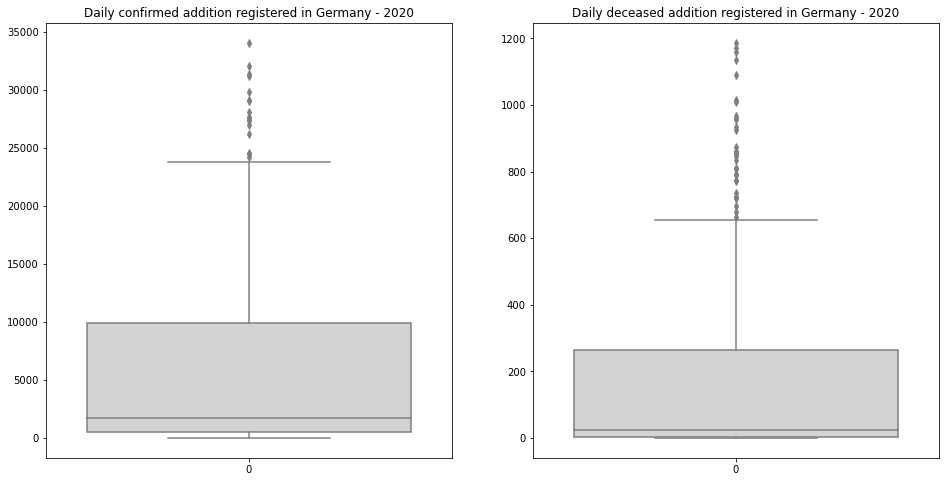

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(data =corona_daily_sum['confirmed_addition'], color='lightgray',ax = ax1).set_title('Daily confirmed addition registered in Germany - 2020');
sns.boxplot(data = corona_daily_sum['deceased_addition'], color='lightgray',ax = ax2).set_title('Daily deceased addition registered in Germany - 2020');

# Task 1 - Single Variable Analysis

## Corona

### Region - per capita

In [32]:
#grouping the corona_dataset by region and adding the population

meta_df = pd.DataFrame(country_metadata['country_metadata'])
sorted_country_metadata = meta_df.sort_values(by = 'iso3166-2_name_en')
corona_by_region  = pd.DataFrame(raw_data['de_corona'].groupby(by = 'region_code').sum())
corona_by_region['iso3166-2_code'] = sorted_country_metadata['iso3166-2_code'].values
corona_by_region['population'] = sorted_country_metadata['population'].values

corona_by_region

confirmed_addition  deceased_addition iso3166-2_code  \
region_code                                                                    
Baden-Württemberg                   311152               7940          DE-BW   
Bayern                              428996              12123          DE-BY   
Berlin                              126896               2728          DE-BE   
Brandenburg                          74955               2914          DE-BB   
Bremen                               17485                327          DE-HB   
Hamburg                              50291               1223          DE-HH   
Hessen                              184434               5672          DE-HE   
Mecklenburg-Vorpommern               23436                692          DE-MV   
Niedersachsen                       159191               4104          DE-NI   
Nordrhein-Westfalen                 521548              12632          DE-NW   
Rheinland-Pfalz                     100118               2993          DE-RP   
Saarland                             28056                848          DE-SL   
Sachsen                             190813               7460          DE-SN   
Sachsen-Anhalt                       58674               2293          DE-ST   
Schleswig-Holstein                   41113               1211          DE-SH   
Thüringen                            73702               2742          DE-TH   

                        population  
region_code                         
Baden-Württemberg         11069533  
Bayern                    13076721  
Berlin                     3644826  
Brandenburg                2511917  
Bremen                      682986  
Hamburg                    1841179  
Hessen                     6265809  
Mecklenburg-Vorpommern     1609675  
Niedersachsen              7982448  
Nordrhein-Westfalen       17932651  
Rheinland-Pfalz            4084844  
Saarland                    990509  
Sachsen                    4077937  
Sachsen-Anhalt             2208321  
Schleswig-Holstein         2896712  
Thüringen                  2143145

In [33]:
#The number of cases by region/capita
corona_by_region['confirmed/pop'] = corona_by_region['confirmed_addition']/corona_by_region['population']
corona_by_region['deceased/pop'] = corona_by_region['deceased_addition']/corona_by_region['population']

In [34]:
corona_by_region.groupby("region_code")["deceased/pop", "confirmed/pop"].describe()

<ipython-input-34-73c6ac334d37>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_by_region.groupby("region_code")["deceased/pop", "confirmed/pop"].describe()


deceased/pop                                    \
                              count      mean std       min       25%   
region_code                                                             
Baden-Württemberg               1.0  0.000717 NaN  0.000717  0.000717   
Bayern                          1.0  0.000927 NaN  0.000927  0.000927   
Berlin                          1.0  0.000748 NaN  0.000748  0.000748   
Brandenburg                     1.0  0.001160 NaN  0.001160  0.001160   
Bremen                          1.0  0.000479 NaN  0.000479  0.000479   
Hamburg                         1.0  0.000664 NaN  0.000664  0.000664   
Hessen                          1.0  0.000905 NaN  0.000905  0.000905   
Mecklenburg-Vorpommern          1.0  0.000430 NaN  0.000430  0.000430   
Niedersachsen                   1.0  0.000514 NaN  0.000514  0.000514   
Nordrhein-Westfalen             1.0  0.000704 NaN  0.000704  0.000704   
Rheinland-Pfalz                 1.0  0.000733 NaN  0.000733  0.000733   
Saarland                        1.0  0.000856 NaN  0.000856  0.000856   
Sachsen                         1.0  0.001829 NaN  0.001829  0.001829   
Sachsen-Anhalt                  1.0  0.001038 NaN  0.001038  0.001038   
Schleswig-Holstein              1.0  0.000418 NaN  0.000418  0.000418   
Thüringen                       1.0  0.001279 NaN  0.001279  0.001279   

                                                     confirmed/pop            \
                             50%       75%       max         count      mean   
region_code                                                                    
Baden-Württemberg       0.000717  0.000717  0.000717           1.0  0.028109   
Bayern                  0.000927  0.000927  0.000927           1.0  0.032806   
Berlin                  0.000748  0.000748  0.000748           1.0  0.034815   
Brandenburg             0.001160  0.001160  0.001160           1.0  0.029840   
Bremen                  0.000479  0.000479  0.000479           1.0  0.025601   
Hamburg                 0.000664  0.000664  0.000664           1.0  0.027315   
Hessen                  0.000905  0.000905  0.000905           1.0  0.029435   
Mecklenburg-Vorpommern  0.000430  0.000430  0.000430           1.0  0.014559   
Niedersachsen           0.000514  0.000514  0.000514           1.0  0.019943   
Nordrhein-Westfalen     0.000704  0.000704  0.000704           1.0  0.029084   
Rheinland-Pfalz         0.000733  0.000733  0.000733           1.0  0.024510   
Saarland                0.000856  0.000856  0.000856           1.0  0.028325   
Sachsen                 0.001829  0.001829  0.001829           1.0  0.046792   
Sachsen-Anhalt          0.001038  0.001038  0.001038           1.0  0.026570   
Schleswig-Holstein      0.000418  0.000418  0.000418           1.0  0.014193   
Thüringen               0.001279  0.001279  0.001279           1.0  0.034390   

                                                                              
                       std       min       25%       50%       75%       max  
region_code                                                                   
Baden-Württemberg      NaN  0.028109  0.028109  0.028109  0.028109  0.028109  
Bayern                 NaN  0.032806  0.032806  0.032806  0.032806  0.032806  
Berlin                 NaN  0.034815  0.034815  0.034815  0.034815  0.034815  
Brandenburg            NaN  0.029840  0.029840  0.029840  0.029840  0.029840  
Bremen                 NaN  0.025601  0.025601  0.025601  0.025601  0.025601  
Hamburg                NaN  0.027315  0.027315  0.027315  0.027315  0.027315  
Hessen                 NaN  0.029435  0.029435  0.029435  0.029435  0.029435  
Mecklenburg-Vorpommern NaN  0.014559  0.014559  0.014559  0.014559  0.014559  
Niedersachsen          NaN  0.019943  0.019943  0.019943  0.019943  0.019943  
Nordrhein-Westfalen    NaN  0.029084  0.029084  0.029084  0.029084  0.029084  
Rheinland-Pfalz        NaN  0.024510  0.024510  0.024510  0.024510  0.024510  
Saarland

Standard deviation returns NaN because the values are too small so the standard deviation would be insignificant.

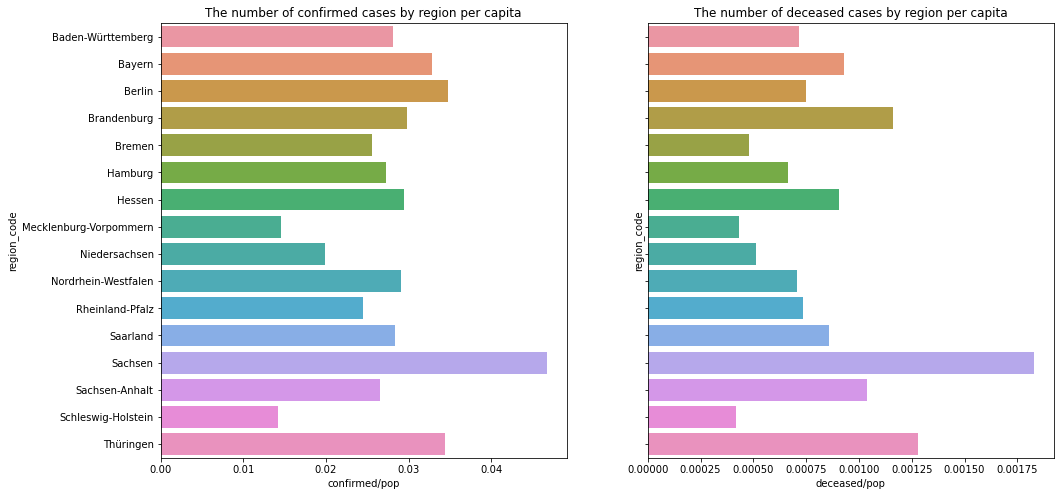

In [35]:
rcParams['figure.figsize'] = 16,8
data_forplot= corona_by_region.copy()
data_forplot['region_code'] = data_forplot.index
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax = sns.barplot(x="confirmed/pop", y="region_code", data=data_forplot,ax=ax1).set_title('The number of confirmed cases by region per capita')
ax = sns.barplot(x="deceased/pop", y="region_code", data=data_forplot,ax=ax2).set_title('The number of deceased cases by region per capita');

### Per Month

In [36]:
corona_date = pd.to_datetime(raw_data['de_corona']['date'])
corona_2020=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2020])
corona_2021=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2021])

corona_2021_month_sum = pd.DataFrame(corona_2021.groupby(corona_date.dt.month).sum())
corona_month_sum = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).sum())
corona_month_mean = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).mean())
#corona_month_mean
right_one = corona_month_sum.append(corona_2021_month_sum)
#right_one

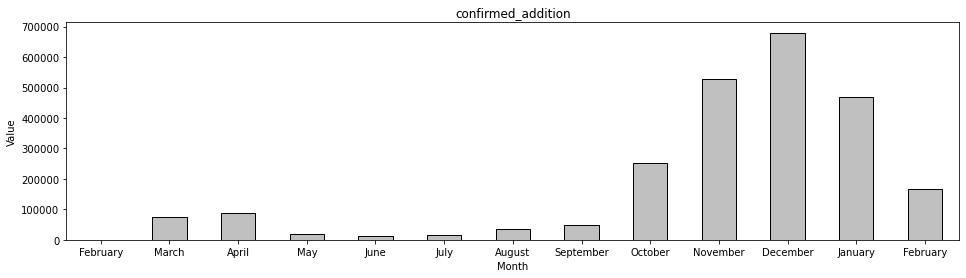

In [37]:
corona_total_bar_plot('confirmed_addition',right_one[1:])

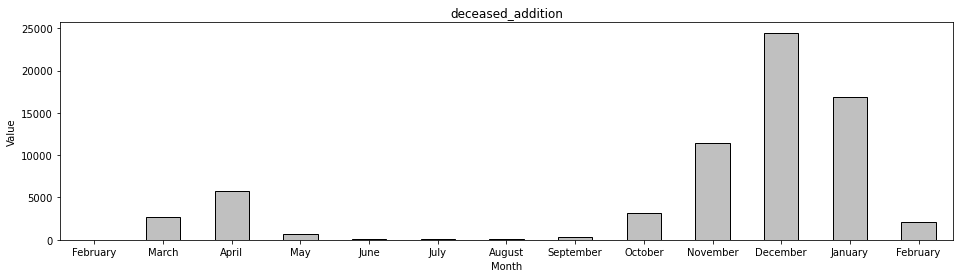

In [38]:
corona_total_bar_plot('deceased_addition',right_one[1:])

### Per Region

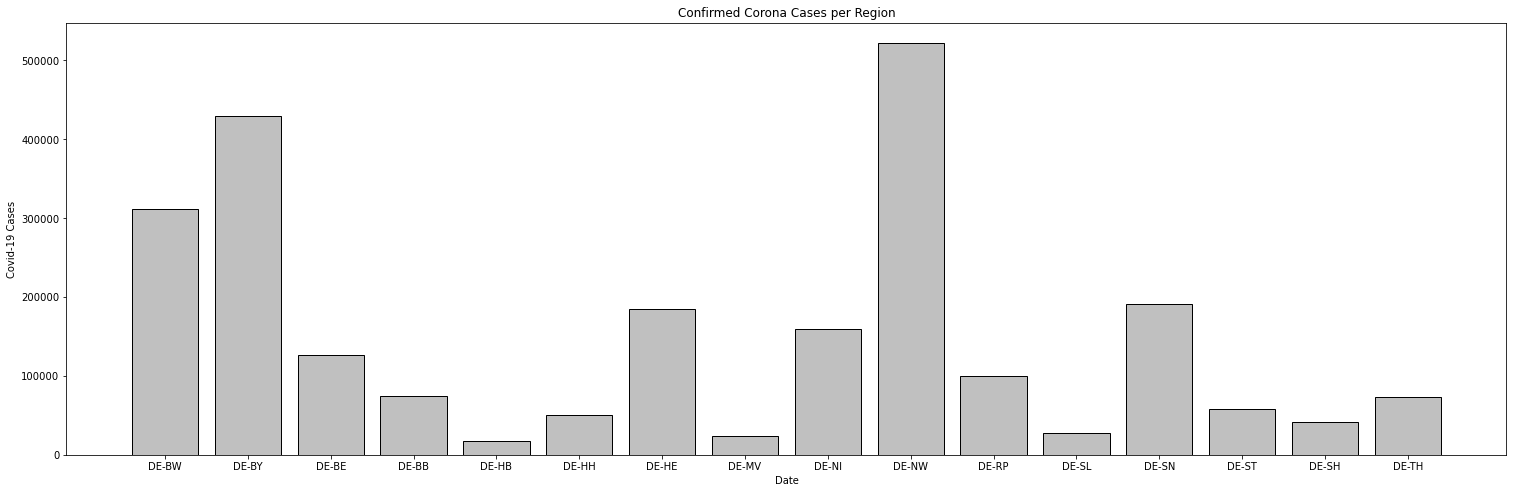

In [39]:
corona_bar_plot(corona_by_region['iso3166-2_code'],corona_by_region['confirmed_addition'],'Confirmed Corona Cases per Region') #potential use

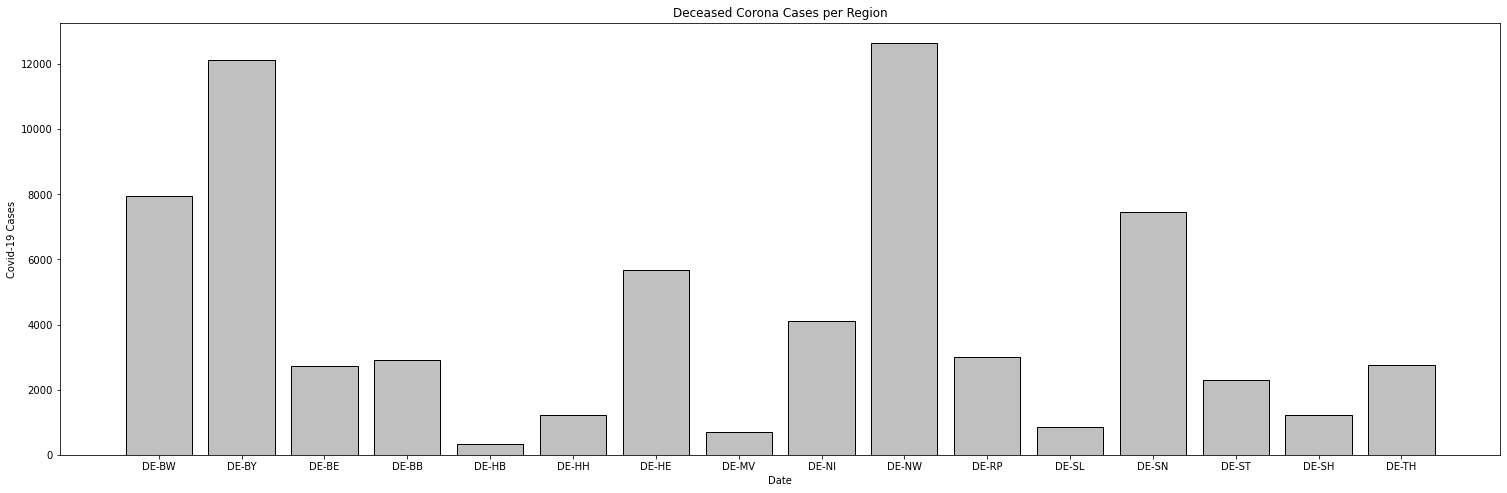

In [40]:
corona_bar_plot(corona_by_region['iso3166-2_code'],corona_by_region['deceased_addition'],'Deceased Corona Cases per Region') #potential use

## Weather

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


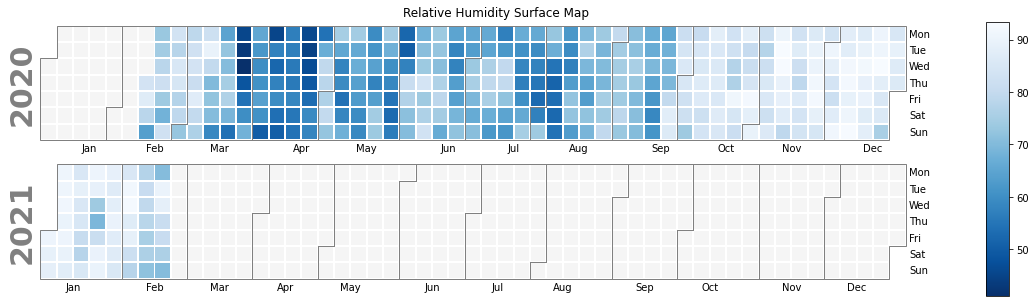

In [41]:
heat_calendar(weather_daily,'RelativeHumiditySurface','Blues_r','Relative Humidity Surface Map')

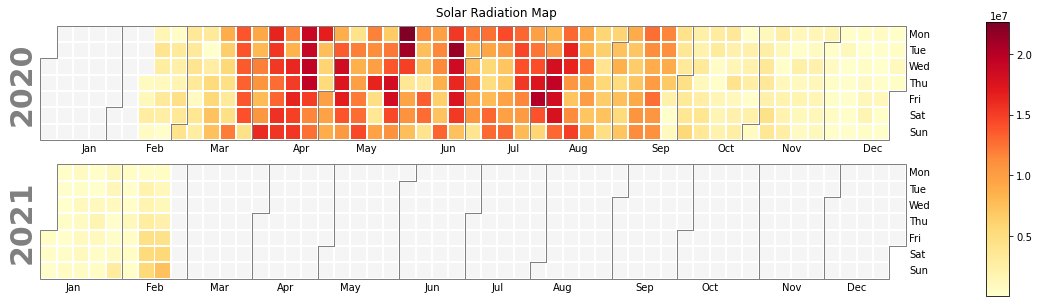

In [42]:
heat_calendar(weather_daily,'SolarRadiation','YlOrRd','Solar Radiation Map');

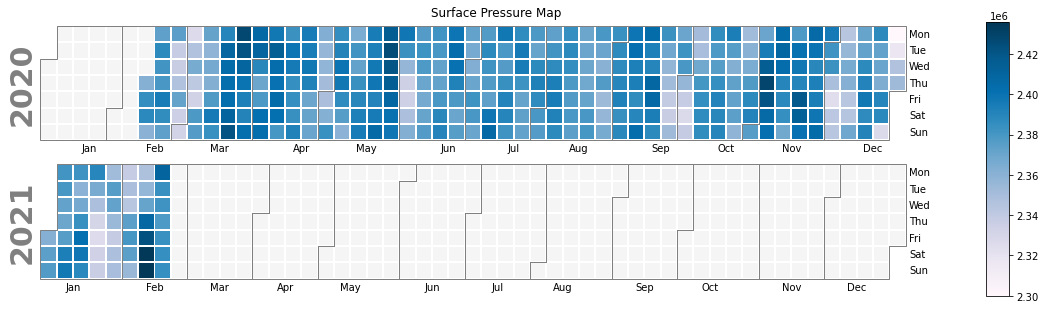

In [43]:
heat_calendar(weather_daily,'Surfacepressure','PuBu','Surface Pressure Map');

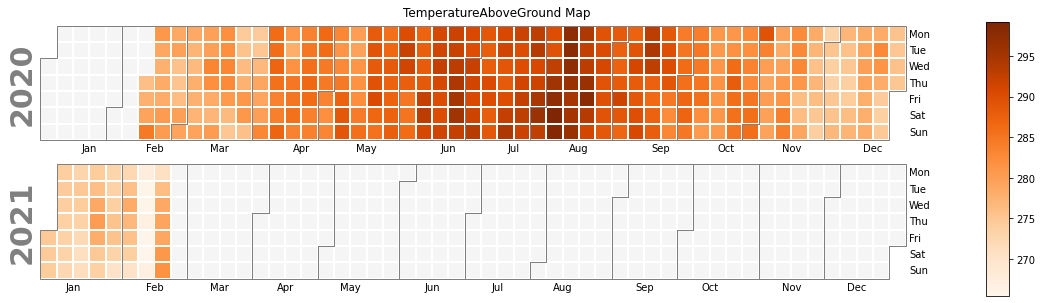

In [44]:
heat_calendar(weather_daily,'TemperatureAboveGround','Oranges','TemperatureAboveGround Map');

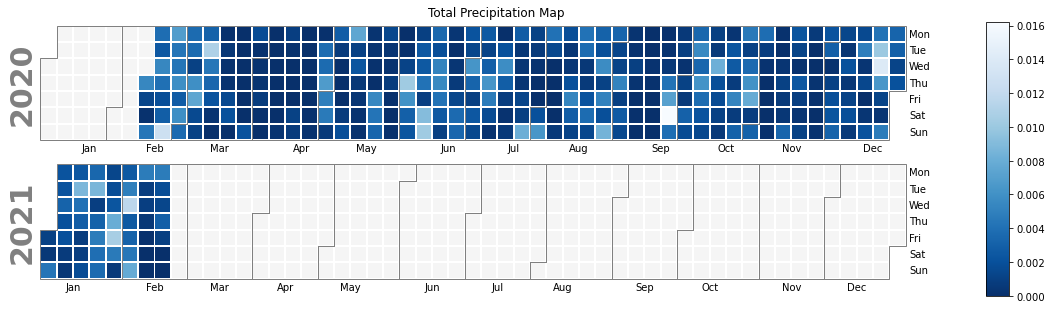

In [45]:
heat_calendar(weather_daily,'Totalprecipitation','Blues_r','Total Precipitation Map');

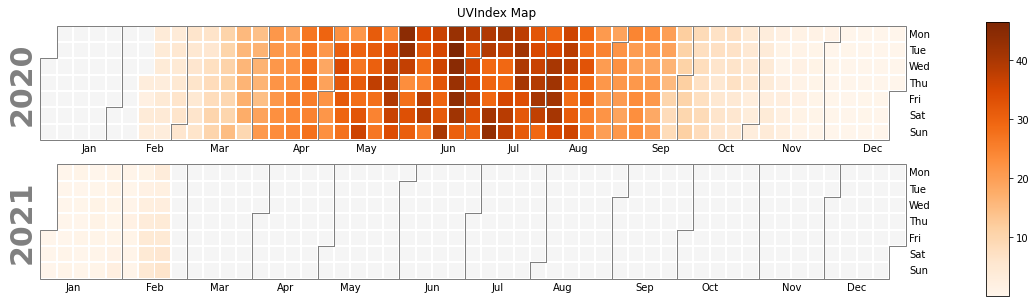

In [46]:
heat_calendar(weather_daily,'UVIndex','Oranges','UVIndex Map');

UVIndex values are a daily sum so it is much higher than expected and the night is taken into consideration as well where the UVIndex is 0.

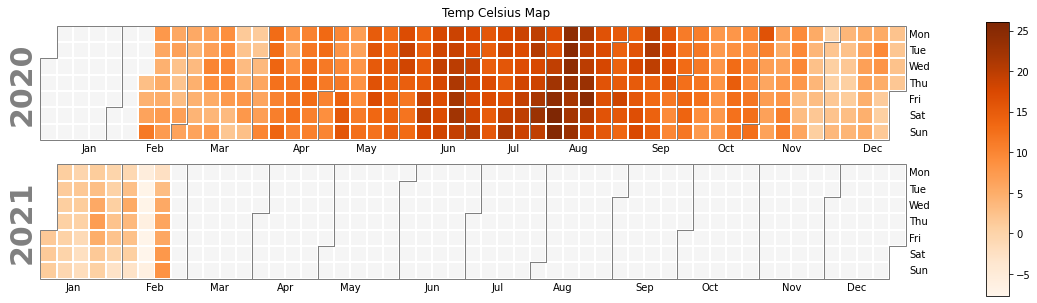

In [47]:
heat_calendar(weather_daily,'Temp_Celsius','Oranges','Temp Celsius Map');

# Task 2 - Associations

## Daily Associations

In [48]:
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Temp_Celsius']
significance_threshold = 0.001 / (len(weather_headers) * 3)

We do the significance threshold with a really small numerator to make sure that it rejects the null hypothesis (it does not occur by chance). We do eight tests times three because we do three different association tests. We update the significance threshold by using the Bonferroni Correction.


### Pearson association for daily_corona_weather for original dataset

Testing for linearity in the data

In [49]:
pearson_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.34264     1.6645350728481603e-153 True 

SolarRadiation 
 -0.34636     4.9463537017058293e-157 True 

Surfacepressure 
 -0.25441     3.724268829474388e-83 True 

Totalprecipitation 
 0.04607     0.0005757858841694551 False 

UVIndex 
 -0.42445     6.229321949127303e-243 True 

WindSpeed 
 -0.03342     0.0125469030820965 False 

Temp_Celsius 
 -0.36396     2.2266597734583237e-174 True 



Visualizing the pearson correlation

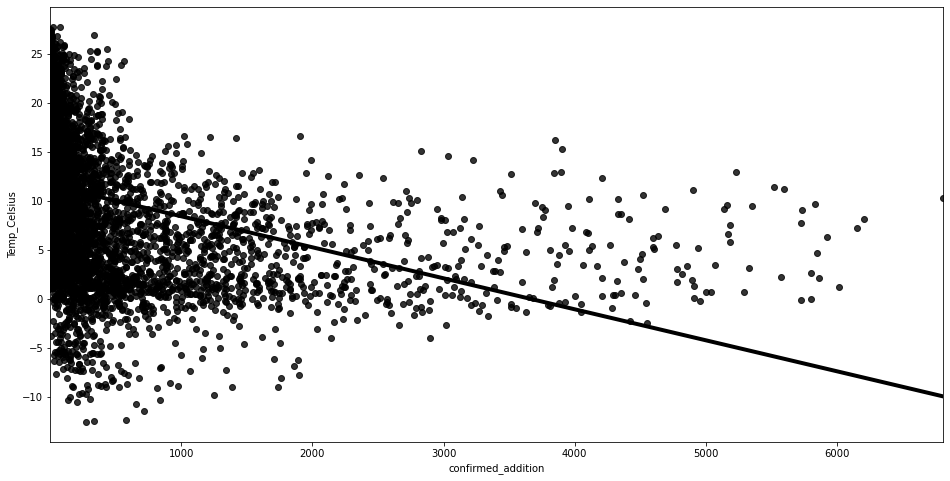

In [50]:
sns.regplot(x="confirmed_addition", y="Temp_Celsius", data=daily_corona_weather, color="black", ci=None,line_kws={'lw':4});

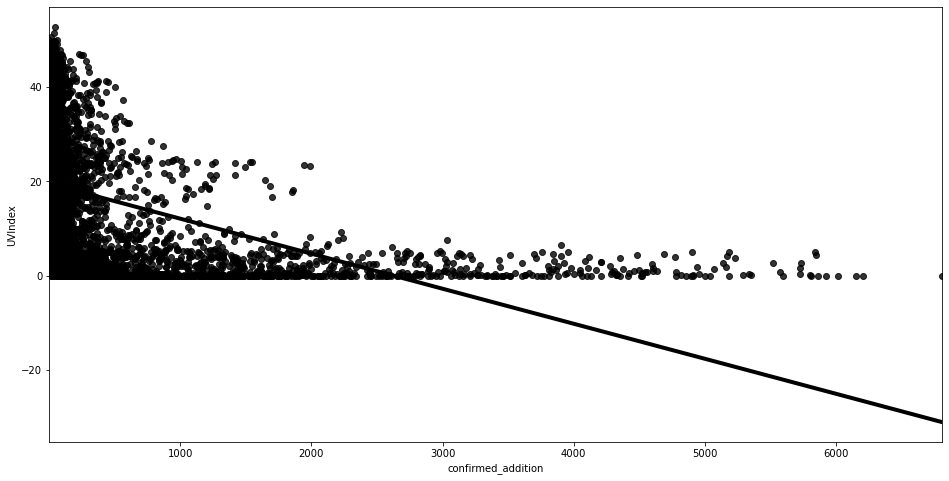

In [51]:
sns.regplot(x="confirmed_addition", y="UVIndex", data=daily_corona_weather, color="black", ci=None, line_kws={'lw':4});

### Spearman association for daily_corona_weather for original dataset.

Testing for monotonic relationships in the data

In [52]:
spearman_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.46803     7.510592264687037e-302 True 

SolarRadiation 
 -0.51605     0.0 True 

Surfacepressure 
 -0.23857     4.681330884969123e-73 True 

Totalprecipitation 
 0.07239     6.176316724575035e-08 True 

UVIndex 
 -0.65459     0.0 True 

WindSpeed 
 -0.01401     0.29525564389645925 False 

Temp_Celsius 
 -0.57797     0.0 True 



### Pearson asscociation for daily_corona_weather, with logtransformation of confirmed_addition

In [53]:
pearson_log(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.41403     4.465717549851026e-230 True 

SolarRadiation 
 -0.46229     1.3964902146213911e-293 True 

Surfacepressure 
 -0.24617     8.231085478913814e-78 True 

Totalprecipitation 
 0.01959     0.14347617674677865 False 

UVIndex 
 -0.61657     0.0 True 

WindSpeed 
 -0.01785     0.18243458231841966 False 

Temp_Celsius 
 -0.54421     0.0 True 



Testing if there is a linear relationship on a non-linear scale in the data and if the data is skewed, thus a log transformation is used.


### Association tests for the deceased corona additon

In [54]:
pearson_association(daily_corona_weather,'deceased_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.28567     2.8636073745510127e-105 True 

SolarRadiation 
 -0.30239     2.4821159440924273e-118 True 

Surfacepressure 
 -0.2644     6.633253681062469e-90 True 

Totalprecipitation 
 0.03276     0.014406248063732842 False 

UVIndex 
 -0.3987     5.509174239699574e-212 True 

WindSpeed 
 -0.0133     0.3203927750096844 False 

Temp_Celsius 
 -0.39378     2.238565678178991e-206 True 



In [55]:
spearman_association(daily_corona_weather,'deceased_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.39763     9.261049010143888e-211 True 

SolarRadiation 
 -0.46224     1.613376804147463e-293 True 

Surfacepressure 
 -0.20186     2.1516133275312377e-52 True 

Totalprecipitation 
 0.04083     0.0022821199452935604 False 

UVIndex 
 -0.63257     0.0 True 

WindSpeed 
 0.03843     0.004086210455727461 False 

Temp_Celsius 
 -0.62728     0.0 True 



In [56]:
#can't be done because of 0 values
#pearson_log(daily_corona_weather,'deceased_addition',weather_headers,significance_threshold)

### sm.ols (Least Squares) multivariate regression


Values here may be misleading. This is because the multivariate regression, when looking at specific variables, it keeps all the other variables constant.

In [57]:
df = sm.add_constant(daily_corona_weather)
weather_headers.extend(["const"])

In [58]:
est = sm.OLS(np.log(df["confirmed_addition"]), df[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     740.2
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:47:23   Log-Likelihood:                -10196.
No. Observations:                5580   AIC:                         2.041e+04
Df Residuals:                    5572   BIC:                         2.046e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

Here TemperatureAboveGround is a misleading variable, since in the previous sections we analysed that having a higher temperature leads to fewer cases. Though in this multiplevariate regression it is found out that a higher temperature increases the number of cases, this contradicts all prior analysis. The reason for this is that the multivariate regression keeps all other variables constant. That is, a day with the exact same weather conditions, besides the temperature being higher, will lead to more cases. To this there could be multiple reasons for this to occur, though a major and probable reason could be that people go outside during high temperatures, which in turn will lead to people not being isolated and thus there will be a higher probability of people getting a Covid-19 infection. 

Thus all these weather variables lead to change in human behavior, which results in changes in the amount of Covid-19 cases.

In [59]:
est = sm.OLS(df["deceased_addition"], df[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:      deceased_addition   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     269.2
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:47:23   Log-Likelihood:                -25255.
No. Observations:                5580   AIC:                         5.053e+04
Df Residuals:                    5572   BIC:                         5.058e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

All the weather variables does not result in anything interesting to be discorvered. From the multivariate regression it is apparent that more people die, with a covid-19 infection, during higher solar radiation. It also shows that fewer people die when the total precipitation is higher. Intuitively these variables does change the human behavior, but in no way that would cause them to reduce or increase the number of deaths caused by covid-19. Also the people dying of Covid-19 is most likely in a hospital bed and is under extensive care, thus intuitively these weather variables would not lead to changes in covid-19 deaths. 

The only explanation would be that the hospital care is worsened during good weather and better during poor weather. Which also does not make much sense intuitively.

In [60]:
#corona and weather conditions grouped by months
weather_date = pd.to_datetime(weather_data_de['date'])
weather_2020=pd.DataFrame(weather_data_de[weather_date.dt.year == 2020])
weather_month_2020 = pd.DataFrame(weather_2020.groupby(weather_date.dt.month).mean())
df_monthly_sum = corona_month_sum.merge(weather_month_2020,left_on = 'date',right_on = 'date')

In [61]:
weather_headers_month = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']
significance_threshold_monthly = 0.5 / (len(weather_headers_month) * 3)
print(significance_threshold_monthly)

0.023809523809523808


Here the significance threshhold is increased due to the grouping of the data into months. This means that the breakpoint of where a variable is as not being correlated by chance is higher, which means that the certainty that the variable is a correlated by chance is less precise. 

#### Corona Cases per Month

In [62]:
pearson_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

RelativeHumiditySurface 
 0.7673     0.005843723167201909 True 

SolarRadiation 
 -0.70074     0.01630731236572748 True 

Surfacepressure 
 -0.16076     0.6367880351381682 False 

TemperatureAboveGround 
 -0.59561     0.05317549012096437 False 

Totalprecipitation 
 -0.16221     0.633712882339746 False 

UVIndex 
 -0.69062     0.018634491071368844 True 

WindSpeed 
 -0.0986     0.7730279658049699 False 



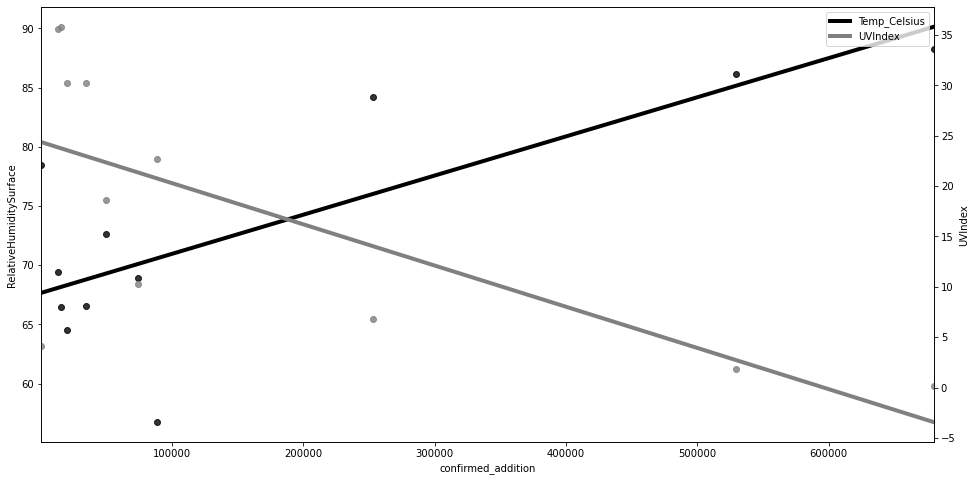

In [63]:
#a scatterplot of two variables, x and y, 
#regression line - fit a line to the data by calculating R^2 (sum of least squares)
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="confirmed_addition", y="RelativeHumiditySurface", data=df_monthly_sum, ax=ax, color="black", ci=None,line_kws={'lw':4})
sns.regplot(x="confirmed_addition", y="UVIndex", data=df_monthly_sum, color="gray", ax=ax2, ci=None, line_kws={'lw':4})

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Temp_Celsius", "UVIndex"])
plt.show()

In [64]:
spearman_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

RelativeHumiditySurface 
 0.43636     0.17966487658001123 False 

SolarRadiation 
 -0.45455     0.16014543725525882 False 

Surfacepressure 
 0.13636     0.6893090205863619 False 

TemperatureAboveGround 
 -0.50909     0.10973723224165641 False 

Totalprecipitation 
 -0.4     0.22286835013352002 False 

UVIndex 
 -0.62727     0.03884525362035334 False 

WindSpeed 
 0.18182     0.5926152128455 False 



In [65]:
pearson_log(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

RelativeHumiditySurface 
 0.28808     0.3903134625969444 False 

SolarRadiation 
 -0.17576     0.6052024831278962 False 

Surfacepressure 
 0.18736     0.5811833182843102 False 

TemperatureAboveGround 
 -0.15762     0.643470637900919 False 

Totalprecipitation 
 -0.62725     0.03885571878005348 False 

UVIndex 
 -0.2488     0.4606764423026103 False 

WindSpeed 
 -0.60545     0.04838865553011275 False 



From these multivariate regressions it is apparent from the pearson that there is a correlation between the monthly total of Covid-19 cases and RelativeHumiditySurface, SolarRadiation and UVIndex. These variables tend to be higher during the summer, where there was a decrease in Covid-19 cases, thus this makes sense. Though in the spearman there is also seen high correlations, though the p-value is too high for us to assume that it has not happend by chance.

#### Corona Deaths per Month

In [66]:
pearson_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

RelativeHumiditySurface 
 0.59644     0.05276325192559332 False 

SolarRadiation 
 -0.56333     0.07113931561053365 False 

Surfacepressure 
 -0.26889     0.4239808658966754 False 

TemperatureAboveGround 
 -0.62049     0.041656472619741765 False 

Totalprecipitation 
 -0.1506     0.6584923054810435 False 

UVIndex 
 -0.60706     0.047636968455584315 False 

WindSpeed 
 -0.06473     0.850018113995279 False 



In [67]:
spearman_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

RelativeHumiditySurface 
 0.33636     0.31182431390038623 False 

SolarRadiation 
 -0.29091     0.38545696969136556 False 

Surfacepressure 
 0.24545     0.4669223669820163 False 

TemperatureAboveGround 
 -0.58182     0.060419896215648305 False 

Totalprecipitation 
 -0.46364     0.15090149929248603 False 

UVIndex 
 -0.57273     0.06554305260101842 False 

WindSpeed 
 0.27273     0.41714143714253127 False 



In [68]:
pearson_log(df_monthly_sum[1:],'deceased_addition',weather_headers_month,significance_threshold_monthly) #interesting, check temperature above ground

RelativeHumiditySurface 
 0.54152     0.10593963742360218 False 

SolarRadiation 
 -0.66768     0.034885281135573994 False 

Surfacepressure 
 -0.04671     0.8980424243400416 False 

TemperatureAboveGround 
 -0.93943     5.472421088040647e-05 True 

Totalprecipitation 
 -0.32285     0.3628904668764907 False 

UVIndex 
 -0.87318     0.0009684152173480638 True 

WindSpeed 
 0.56766     0.08695765569018091 False 



The analysis of the corona cases/deaths per month could be interesting when it is analyzed how infectious one strain is from another. This would be quite hard to do daily because there is really hard that 1st of February 2020 would have the same weather conditions as 1st of February 2021. Therefore, there is a higher chance that the overall weather conditions in February 2020 to be the similar to February 2021.

### Dummy Variable Analysis

In [69]:
daily_corona_weather['Lockdown'] = '0'
daily_corona_weather.loc[(daily_corona_weather["date"] >= "2020-11-02") & (daily_corona_weather["date"] <= "2021-03-07"), "Lockdown"] = '1'
daily_corona_weather['OneMonthAfter_Lockdown'] = '0'
daily_corona_weather.loc[(daily_corona_weather["date"] >= "2020-12-02") & (daily_corona_weather["date"] <= "2021-03-07"), "OneMonthAfter_Lockdown"] = '1'
daily_corona_weather

date  confirmed_addition  deceased_addition iso3166-2  \
0    2020-02-16                   1                  0     DE-MV   
1    2020-02-17                   1                  0     DE-BB   
2    2020-02-18                   1                  0     DE-BB   
3    2020-02-20                   1                  0     DE-NW   
4    2020-02-24                   1                  0     DE-BW   
...         ...                 ...                ...       ...   
5575 2021-02-21                 120                  0     DE-RP   
5576 2021-02-21                  68                  0     DE-SN   
5577 2021-02-21                  84                  0     DE-ST   
5578 2021-02-21                 113                  0     DE-SH   
5579 2021-02-21                 131                  0     DE-TH   

      RelativeHumiditySurface  SolarRadiation  Surfacepressure  \
0                   69.818665    4.562424e+04     2.392858e+06   
1                   64.189273    9.007504e+05     2.409194e+06   
2                   71.904630    4.042940e+06     2.421421e+06   
3                   81.738535    1.064802e+06     2.383996e+06   
4                   80.314208    6.604918e+05     2.308155e+06   
...                       ...             ...              ...   
5575                65.642820    8.457394e+06     2.348996e+06   
5576                74.638170    6.687276e+06     2.363996e+06   
5577                69.587170    7.276057e+06     2.408002e+06   
5578                78.077610    5.698494e+06     2.431487e+06   
5579                68.218962    7.882624e+06     2.341659e+06   

      TemperatureAboveGround  Totalprecipitation   UVIndex  WindSpeed  \
0                 284.294049            0.004641  0.211216   7.888859   
1                 282.312595            0.001005  2.631685   6.319781   
2                 279.679468            0.002388  4.037911   6.150824   
3                 279.663867            0.006802  3.524003   6.477330   
4                 281.894530            0.005284  5.613589   4.663207   
...                      ...                 ...       ...        ...   
5575              282.123657            0.000000  7.879810   3.009041   
5576              279.277820            0.000008  5.409593   4.648033   
5577              282.418775            0.000000  5.273630   2.972845   
5578              281.943486            0.000000  4.474084   2.532838   
5579              281.447381            0.000000  6.547098   3.340947   

      Temp_Celsius Lockdown OneMonthAfter_Lockdown  
0        11.144049        0                      0  
1         9.162595        0                      0  
2         6.529468        0                      0  
3         6.513867        0                      0  
4         8.744530        0                      0  
...            ...      ...                    ...  
5575      8.973657        1                      1  
5576      6.127820        1                      1  
5577      9.268775        1                      1  
5578      8.793486        1                      1  
5579      8.297381        1                      1  

[5580 rows x 14 columns]

In [70]:
mask = (corona_df['date'] > "2020-11-02") & (corona_df['date'] <= "2021-03-07")
corona_daily_sum_lockdown = corona_df[mask].groupby(corona_df[mask]['date']).sum().reset_index()
#corona_daily_sum_lockdown

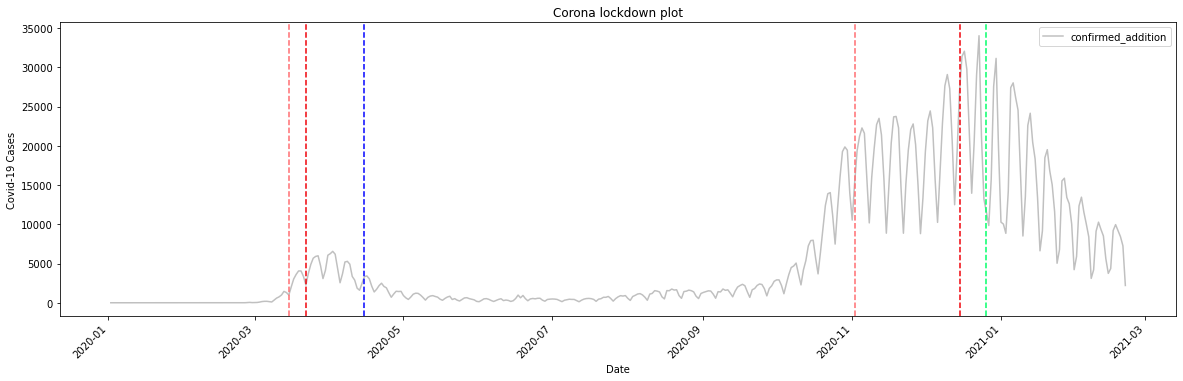

In [71]:
corona_line_plot(corona_daily_sum,'date','confirmed_addition','Corona lockdown plot')

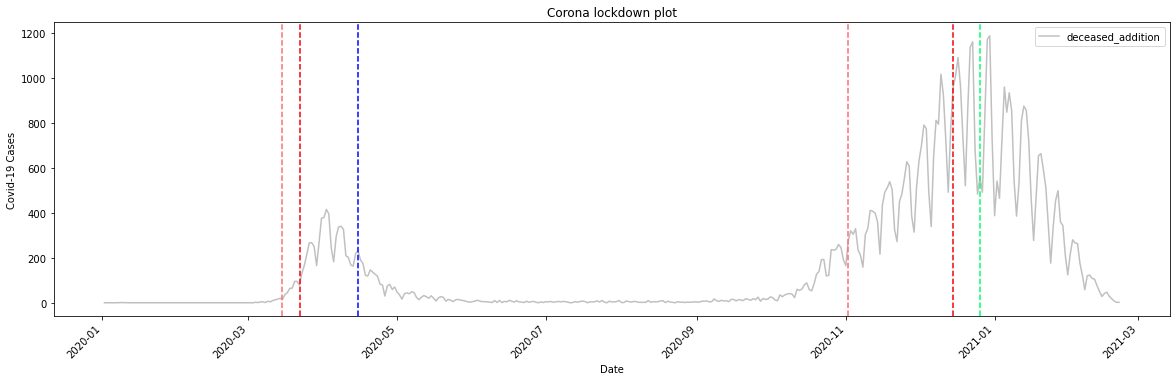

In [72]:
corona_line_plot(corona_daily_sum,'date','deceased_addition','Corona lockdown plot')

Data taken from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Germany - Government Reactions

- 15th March, borders to Austria, Denmark, France, Luxembourg and Switzerland were closed (light-red)
- 22nd March, curfews were imposed in six German states while other states prohibited physical contact with more than one person from outside one's household. (dark-red)
- 15th April loosening of restrictions (blue)
- 2nd November a partial lockdown was implemented, in which physical distancing rules were tightened while schools and kindergartens remained open, only temporarily halted the rise in case numbers (light-red)
- 15th December a hard lockdown was implemented (dark-red)
- 26th December 2020 - Vaccinations with the BioNTech–Pfizer COVID-19 vaccine began  (green)

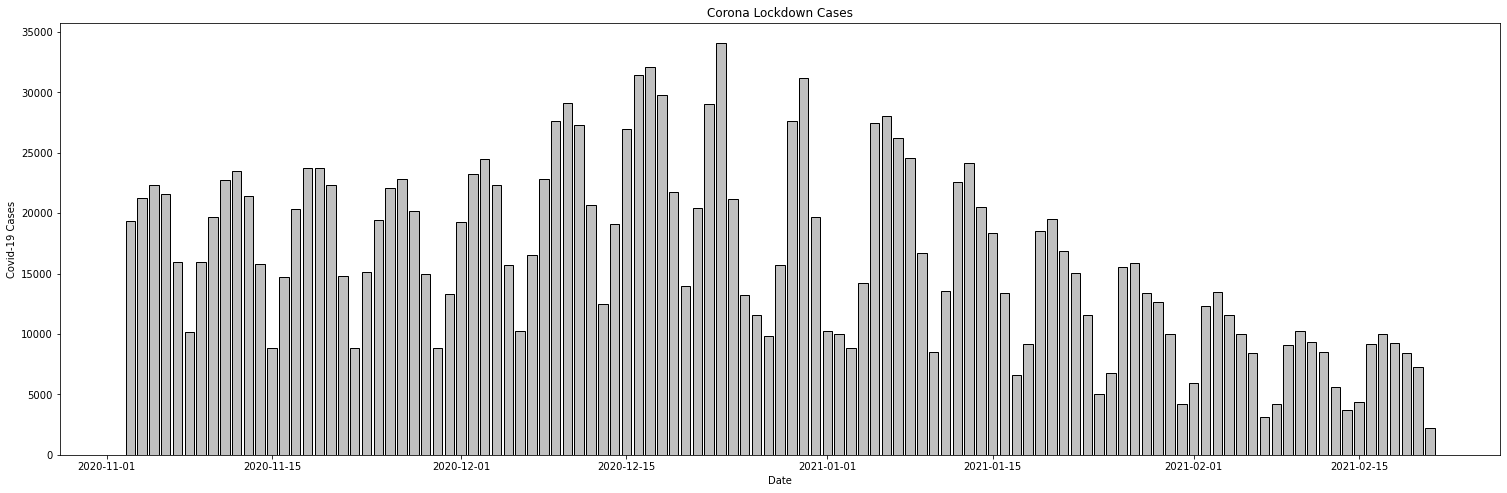

In [73]:
corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['confirmed_addition'],'Corona Lockdown Cases')

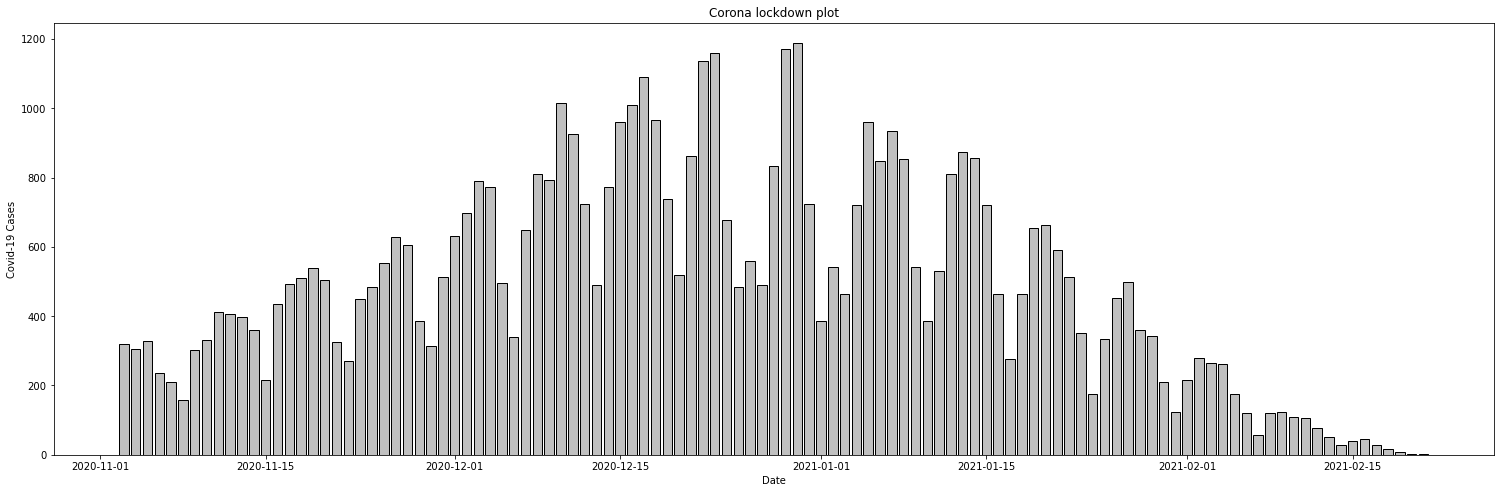

In [74]:
corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['deceased_addition'],'Corona lockdown plot')

In [75]:
x = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Lockdown','const']
df1 = sm.add_constant(daily_corona_weather)
est1 = sm.OLS(np.log(df1['confirmed_addition']), df1[x].astype(float), hasconst = True).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     807.1
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:47:25   Log-Likelihood:                -9882.7
No. Observations:                5580   AIC:                         1.978e+04
Df Residuals:                    5571   BIC:                         1.984e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

The R-squared values changed after the addition of the lockdown variable to our analysis from 0.263 to 0.537. This means a 0.274 increase in our predictive power. It seems the lockdown has a significant positive effect on the number of cases. Intuitively this should not be true. The lockdown can not have an immediate effect. The virus has an incubation time, it would continue to spread until approximately 2 weeks into the lockdown.
To get a more accurate view of what happened after the lockdown some weeks later, a 'OneMonthAfter_lockdown' column was created. One month could be enough to assume enough people can strictly follow the restrictions to see the impact of the lockdown.

In [76]:
x = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','OneMonthAfter_Lockdown','const']
df2 = sm.add_constant(daily_corona_weather)
est1 = sm.OLS(np.log(df2['confirmed_addition']), df2[x].astype(float), hasconst = True).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     693.9
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:47:25   Log-Likelihood:                -10101.
No. Observations:                5580   AIC:                         2.022e+04
Df Residuals:                    5571   BIC:                         2.028e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

# Task 3 - Map visualization

## Total number of Cases of Covid-19 on a regional basis

In [77]:
corona_by_region['confirmed/pop']

region_code
Baden-Württemberg         0.028109
Bayern                    0.032806
Berlin                    0.034815
Brandenburg               0.029840
Bremen                    0.025601
Hamburg                   0.027315
Hessen                    0.029435
Mecklenburg-Vorpommern    0.014559
Niedersachsen             0.019943
Nordrhein-Westfalen       0.029084
Rheinland-Pfalz           0.024510
Saarland                  0.028325
Sachsen                   0.046792
Sachsen-Anhalt            0.026570
Schleswig-Holstein        0.014193
Thüringen                 0.034390
Name: confirmed/pop, dtype: float64

In [78]:
n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_by_region,
    columns = ["iso3166-2_code", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Cases of Covid-19").add_to(n_cases)
n_cases

## Total number of deceased with a confirmed Covid-19 infection on a regional basis


In [79]:
dead = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_by_region,
    columns = ["iso3166-2_code", "deceased_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "Greys", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Deceased with an covid-19 infection").add_to(dead)
dead

## Population on a regional basis 

In [80]:
p_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
folium.Choropleth(
    geo_data = shape,
    name = "population",
    data = corona_by_region,
    columns = ["iso3166-2_code", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Population").add_to(p_cases)
p_cases

## Number of Cases pr. population of region

In [81]:
r_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(r_cases)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_by_region,
    columns = ["iso3166-2_code", "confirmed/pop"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases pr. population of region",
    highlight=True
).add_to(r_cases)

folium.LayerControl().add_to(r_cases)

r_cases

## UVIndex on a regional basis

The UVIndex is a daily sum, this is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small UVIndex values, because UVIndex during the night is taken into account.

In [82]:
# dividing by 24 since there is 24 hours in a day, though this takes into account night where the uvindex is 
# really small/nonexsistent
# Could be argued that it should be divided by 16-18 since these are the hours where the sun is present. 
weather_by_region = pd.DataFrame(weather_data_de.groupby(by = 'iso3166-2').mean())
weather_by_region['UVIndex_scaled'] = weather_by_region['UVIndex']/24

In [83]:
uv_index = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = weather_by_region,
    columns = [weather_by_region.index, "UVIndex_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "UVIndex",
    smooth_factor=0).add_to(uv_index)
uv_index

## Temperature Above Ground on a regional basis

The Temperature Above Ground is a daily sum, this means that the data is flawed and is a lot higher than expected. This is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small temperature values, because the temperature during the night is taken into account. Considering the flaws here this is still a more accurate measure then what the original data would have been. 

In [84]:
weather_by_region["TemperatureAboveGround_scaled"] = weather_by_region["TemperatureAboveGround"]/24

In [85]:
TAG = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = weather_by_region,
    columns = [weather_by_region.index, "TemperatureAboveGround_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "average Temperature Above Ground on a daily basis").add_to(TAG)
TAG

## Multiple plots on a regional and monthy basis

In [86]:
raw_data['de_corona']['month'] = raw_data['de_corona']['date'].dt.strftime('%B')
raw_data['de_corona']['year'] = raw_data['de_corona']['date'].dt.strftime('%Y')
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}
raw_data["de_corona"]["population"] = raw_data["de_corona"]["region"].map(population_map)
raw_data["de_corona"]["confirmed_addition_ratio"] = raw_data["de_corona"]["confirmed_addition"]/(raw_data["de_corona"]["population"]/100_000)

In [87]:
cases_2020_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")].groupby(["month", "region"]).sum()
cases_2021_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")].groupby(["month", "region"]).sum()

In [88]:
cases_2020_monthly.loc["April"]

confirmed_addition  deceased_addition  population  \
region                                                      
DE-BB                 1878                126    75357510   
DE-BE                 3050                152   109344780   
DE-BW                17042               1080   332085990   
DE-BY                24720               1614   392301630   
DE-HB                  592                 28    20489580   
DE-HE                 4814                366   187974270   
DE-HH                 2280                186    55235370   
DE-MV                  270                 13    43461225   
DE-NI                 5571                402   239473440   
DE-NW                17406               1078   537979530   
DE-RP                 3009                163   122545320   
DE-SH                 1436                 98    86901360   
DE-SL                 1590                117    29715270   
DE-SN                 2425                140   122338110   
DE-ST                  786                 26    66249630   
DE-TH                 1442                124    64294350   

        confirmed_addition_ratio  
region                            
DE-BB                  74.763617  
DE-BE                  83.680263  
DE-BW                 153.954101  
DE-BY                 189.038215  
DE-HB                  86.678204  
DE-HE                  76.829664  
DE-HH                 123.833696  
DE-MV                  16.773572  
DE-NI                  69.790621  
DE-NW                  97.063173  
DE-RP                  73.662544  
DE-SH                  49.573447  
DE-SL                 160.523529  
DE-SN                  59.466343  
DE-ST                  35.592652  
DE-TH                  67.284295

In [89]:
confirmed_addition_ratio_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. 100_000 population of region in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. 100_000 population of region in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2021"] = n_cases    

In [90]:
confirmed_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2021"] = n_cases   
confirmed_addition = ["other_notebooks/maps/confirmed_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in confirmed_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/confirmed_addition_maps.gif', images, duration=4)

In [91]:
deceased_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2020".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2021".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2021"] = n_cases   
deceased_addition = ["other_notebooks/maps/deceased_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in deceased_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/deceased_addition_maps.gif', images, duration=4)

### Viewing the maps

All the monthly maps can be ascessed by doing 
```python
deceased_addition_maps["January-2020"]
confirmed_addition_maps["January-2020"]
confirmed_addition_ratio_maps["January-2020"]
```
Missing data, or there was no recorded data in that region, the color of the region will be purple

Month and year can be changed

In [92]:
confirmed_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/confirmed_addition_maps.gif)

In [93]:
deceased_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/deceased_addition_maps.gif)

In [94]:
confirmed_addition_ratio_maps["January-2020"]

#  Task 4: Open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. For example, compare your country to another one in the dataset; or investigate additional variables that you could
find elsewhere (e.g. total population, population density, population demographics such as age distribution,
number of elders, etc); or identify if there are temporal patterns (is one variable more important in some
months? Are weekends different from weekdays? Etc), ..

##### We loaded an external data set from the website of 'Robert Koch Institut' (RKI) to explore the role of age in potentially driving differences in infection spread.
The data set is about  COVID-19 cases by age group / 100,000 inhabitants in Germany from the 17th of March 2020 to the 2nd of March 2021.  
https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Altersverteilung.html

#### The weekly mean of total confirmed cases per 100.000 inhabitants across age groups
We added the mean of the weekly cases by age to the table to get a quick insight into the age distribution.

In [95]:
raw_data['age_pop']['mean'] = raw_data['age_pop'].mean(axis=1)
raw_data['age_pop']

Altersgruppe  2020_11  2020_12  2020_13  2020_14  2020_15  2020_16  \
0        Gesamt     7.72    26.97    40.89    43.39    32.69    20.88   
1           90+     1.58    12.27    51.52   142.28   151.15   103.03   
2       85 - 89     2.43    14.07    47.19    92.59    91.00    59.21   
3       80 - 84     2.58    14.21    38.92    59.68    52.12    35.85   
4       75 - 79     2.94    14.76    36.30    46.10    33.90    22.03   
5       70 - 74     3.92    16.85    36.12    38.57    28.58    17.17   
6       65 - 69     4.88    18.25    33.90    34.82    22.99    13.62   
7       60 - 64     7.56    28.28    44.74    49.26    31.80    19.25   
8       55 - 59    11.15    38.58    53.33    54.46    38.72    23.24   
9       50 - 54    14.57    46.05    59.61    55.09    38.94    23.25   
10      45 - 49    14.05    39.84    55.43    51.58    36.45    22.26   
11      40 - 44    11.53    36.73    47.42    47.02    34.12    20.90   
12      35 - 39    10.34    33.18    45.05    41.69    31.25    18.57   
13      30 - 34     9.73    37.28    48.00    44.00    31.88    21.89   
14      25 - 29    10.76    39.49    53.07    49.01    38.09    25.56   
15      20 - 24     7.03    31.44    49.26    48.69    37.65    26.78   
16      15 - 19     4.65    13.73    23.81    27.34    21.73    14.52   
17      10 - 14     2.73     6.83    10.24    11.61     8.18     6.37   
18        5 - 9     1.50     4.53     6.68     7.86     6.33     4.37   
19        0 - 4     0.91     3.61     6.41     6.87     5.96     4.06   

    2020_17  2020_18  2020_19  ...  2021_1  2021_2  2021_3  2021_4  2021_5  \
0     14.88     8.95     7.50  ...  175.00  143.11  114.96   94.16   77.74   
1     70.59    34.63    25.27  ...  657.56  612.36  479.32  350.41  235.59   
2     43.55    20.85    16.82  ...  388.99  355.16  284.56  212.94  164.98   
3     24.95    13.72     9.08  ...  232.98  203.08  161.73  127.34   95.47   
4     15.14     9.05     7.09  ...  134.89  111.31   88.25   72.90   57.04   
5     11.54     7.48     5.63  ...  131.35   99.64   83.39   67.58   56.23   
6     10.37     5.47     4.28  ...  117.70   90.82   74.60   64.42   52.11   
7     11.93     7.17     5.88  ...  164.12  133.70  110.36   90.83   74.67   
8     15.72     8.91     7.58  ...  182.92  148.92  123.94  104.29   86.27   
9     14.81     9.02     7.75  ...  180.13  146.03  121.99   99.64   78.98   
10    14.98     8.89     8.50  ...  185.73  151.10  122.60  100.73   85.28   
11    14.20     9.29     8.23  ...  194.03  154.00  126.83  104.38   87.33   
12    14.44     8.77     7.96  ...  191.64  151.63  119.85   98.52   84.55   
13    16.52    10.23     8.88  ...  211.02  164.71  127.94  105.19   89.51   
14    19.67    13.42    10.27  ...  212.75  168.23  126.16  105.45   88.44   
15    20.85    12.91    11.02  ...  236.35  184.79  139.81  113.81   95.04   
16    10.18     6.73     6.60  ...  161.93  137.31  106.77   88.37   74.13   
17     5.08     3.67     3.38  ...   89.69   73.64   60.03   50.80   46.64   
18     4.11     3.22     2.82  ...   64.37   59.14   51.01   44.08   43.06   
19     4.67     3.33     3.48  ...   48.64   47.05   42.96   38.80   38.09   

    2021_6  2021_7  2021_8  2021_9        mean  
0    61.19   63.13   67.90   69.71   57.935192  
1   159.16  131.22  100.84   73.87  159.798654  
2   105.90   93.49   77.25   60.75   98.456731  
3    69.79   60.77   54.09   46.47   59.921154  
4    43.91   44.22   40.84   34.62   38.320577  
5    42.89   43.30   44.88   42.21   37.538846  
6    39.49   42.09   43.90   40.81   34.897692  
7    56.54   57.78   62.27   60.20   50.811154  
8    66.87   68.28   71.84   68.01   59.588077  
9    64.17   67.23   70.53   73.04   61.416538  
10   67.53   71.49   76.88   80.80   65.875385  
11   70.69   73.09   84.35   86.60   67.564231  
12   68.16   70.50   79.07   85.74   64.089423  
13   71.02   74.84   82.88   88.60   69.051154  
14   72.09   76.88   81.94   83.63   73.967500  
15   79.51   85.86   91.27   94.96   81.736346

In [96]:
raw_data['age_pop']['mean'].describe()

count     20.000000
mean      62.162125
std       29.404713
min       23.015769
25%       40.729519
50%       60.668846
75%       67.935962
max      159.798654
Name: mean, dtype: float64

#### Visualize distribution of weekly mean of total confirmed cases per 100.000 per age

In [97]:
rcParams['figure.figsize'] = 15,8
sns.set_style("whitegrid");

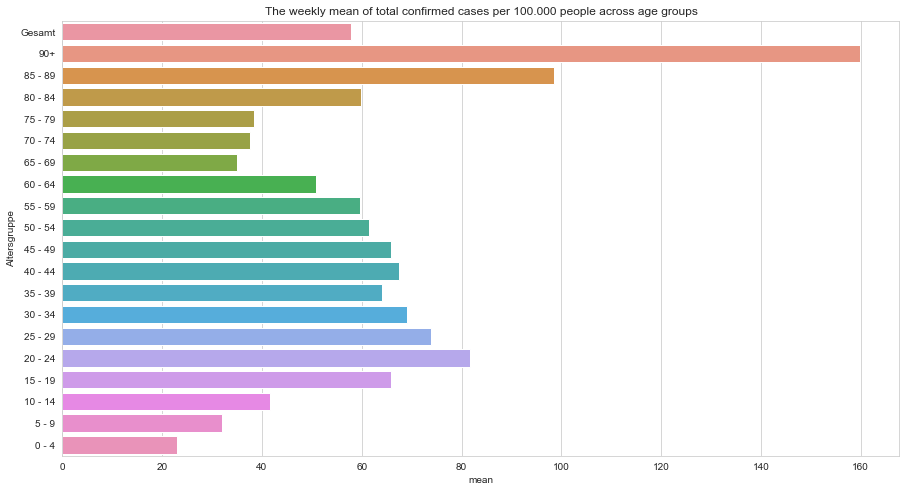

In [98]:
ax = sns.barplot(x="mean", y="Altersgruppe", data=raw_data['age_pop']).set_title('The weekly mean of total confirmed cases per 100.000 people across age groups')

The weekly registered infections among people above 90 is significantly higher than in other age groups. 

The reason does not seem to be the population size of each group. (RKI: 40-59-year-olds make up the largest age group in Germany, at 23.6 million people, the next-largest age group was 65 years and older, at 18.09 million.)

#### Temporal distribution of cases across age groups

In [99]:
df_T = raw_data['age_pop'].T
modified = df_T.reset_index()
new_header = modified.iloc[0] #grab the first row for the header
modified = modified[1:] #take the data less the header row
modified.columns = new_header #set the header row as the df header
modified.rename(columns={"Altersgruppe":"date"}, inplace=True)
modified = modified.drop([53])
modified['date'] = modified['date'].astype(str) + '_2' #2 means Tuesday
modified['date'] =  pd.to_datetime(modified['date'], format='%Y_%W_%w')

for column in modified:
    modified.iloc[:, 1:21] = modified.iloc[:, 1:21].astype(float)

# merge age groups
modified['0-19'] = modified.loc[:,['0 - 4','5 - 9', '10 - 14', '15 - 19']].sum(axis=1)
modified['20-39'] = modified.loc[:,['20 - 24','25 - 29', '30 - 34', '35 - 39']].sum(axis=1)
modified['40-59'] = modified.loc[:,['40 - 44', '45 - 49', '50 - 54', '55 - 59']].sum(axis=1)
modified['60-79'] = modified.loc[:,['60 - 64','65 - 69', '70 - 74', '75 - 79']].sum(axis=1)
modified['80+'] = modified.loc[:,['80 - 84', '85 - 89', '90+']].sum(axis=1)
#modified

The pandemic is exhibiting seasonal patterns in its spread. It is clear that there is a peak in the number of cases in the winter period of 2020-2021 and the number of cases are low during the summer of 2020. 
Next, the distribution of these specific periods will be plotted by ages.

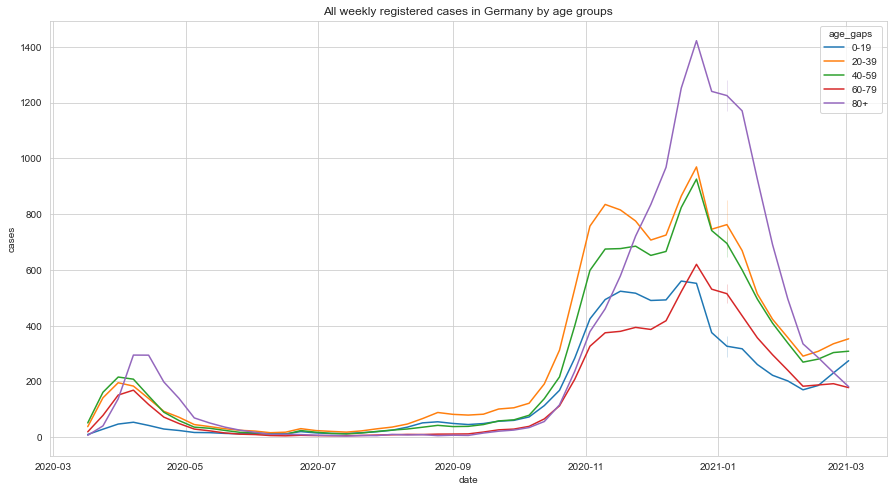

In [100]:
x = modified.drop(modified.columns.difference(['date', '0-19', '20-39', '40-59', '60-79', '80+']), axis=1)
melt_modified = x.melt('date', var_name='age_gaps',  value_name='cases')

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=melt_modified).set_title('All weekly registered cases in Germany by age groups')

In [101]:
mask_winter = (melt_modified['date'].dt.month > 10)
winter = melt_modified[mask_winter]

In [102]:
mask_summer = ((melt_modified['date'].dt.month < 9) & (melt_modified['date'].dt.month > 5))
summer = melt_modified[mask_summer]

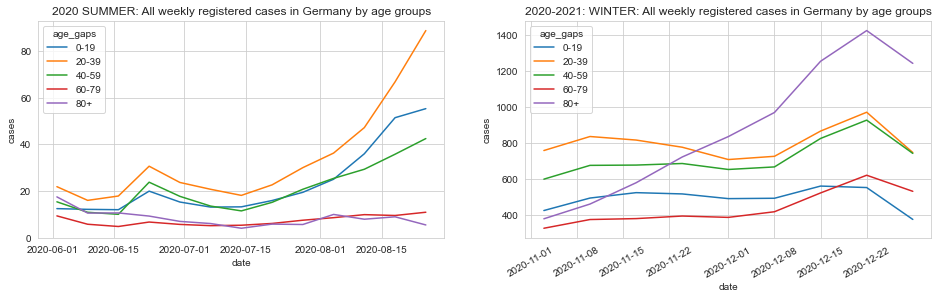

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4))
sns.lineplot(x="date", y="cases", hue='age_gaps',ax=ax2, data=winter).set_title('2020-2021: WINTER: All weekly registered cases in Germany by age groups');
plt.xticks(rotation=30)
sns.lineplot(x="date", y="cases", hue='age_gaps', ax=ax1, data=summer).set_title('2020 SUMMER: All weekly registered cases in Germany by age groups');

However, during the summer, when the overall number of cases are low, the proportion of the infected among young adults are higher, in the age group 20-39 the highest.

By investigating the possible connections between the weather variables and the number of cases by age groups, the focus will be on people from 20 to 39 years and above 80.

In [104]:
#merge corona_age & weather WEEKLY for plots
#corona age: 2020.03.12 - 2021.03.02.  - weather: 2020-02-13 - 2020.11.14.

#prepare weather data to merge without regions
df_w = weather_data_de.copy()
#sum some weather values:
df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
#take the mean some weather values:
df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 
#date index to column data:
df_w_noregions.reset_index(level=0, inplace=True)

#merge (modified is the weekly corona data by age)
weekly_coronaAge_weather = modified.merge(df_w_noregions, left_on = ["date"], right_on = ["date"])
weekly_coronaAge_weather.drop_duplicates(subset='date');

celsius = pd.DataFrame(weekly_coronaAge_weather['TemperatureAboveGround'].subtract(273.15))
weekly_coronaAge_weather['Temp_Celsius'] = celsius

<ipython-input-104-fbda98624fc1>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
<ipython-input-104-fbda98624fc1>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()


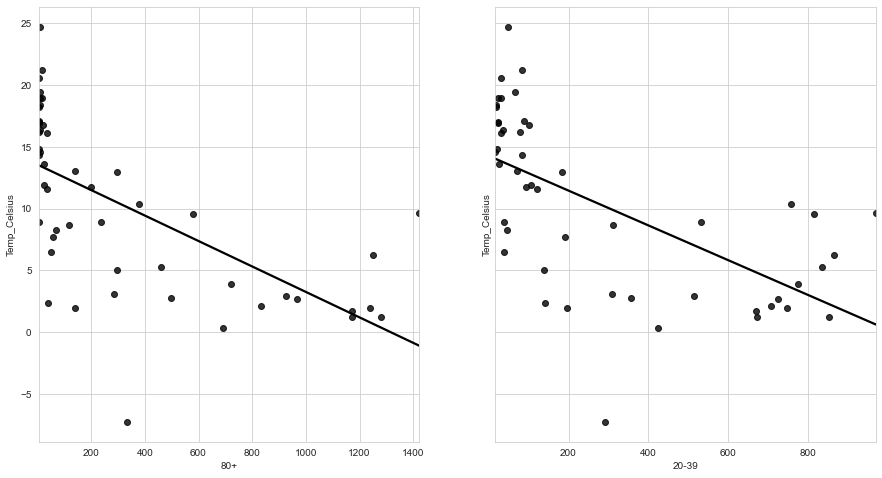

In [105]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x="80+", y="Temp_Celsius", data=weekly_coronaAge_weather, ax=ax1, color="black", ci=None)
sns.regplot(x="20-39", y="Temp_Celsius", data=weekly_coronaAge_weather, ax=ax2, color="black", ci=None);

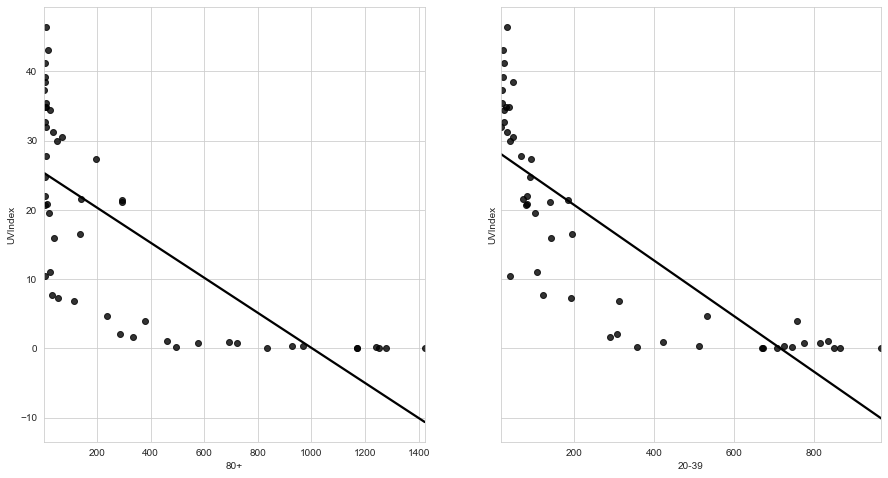

In [106]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x="80+", y="UVIndex", data=weekly_coronaAge_weather, ax=ax1, color="black", ci=None)
sns.regplot(x="20-39", y="UVIndex", data=weekly_coronaAge_weather, ax=ax2, color="black", ci=None);

### Multivariate linear regression using statsmodel for daily_coronaAge_weather 80+

Is there any difference in how each weather variable can influence the number of cases in these two specific age groups? 

In [107]:
#DAILY DATA
#There is data for 52 weeks: create daily data - divide the case numbers by 7
modified['date'] = pd.to_datetime(modified['date'])
daily_age = modified.set_index('date').resample('d').mean().ffill().div(7).reset_index()


#changes in weather data: change values: sum and mean
#df_w = de_weather.copy()
#df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
#df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
#no need for regions
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 
daily_coronaAge_weather = daily_age.merge(df_w_noregions,  left_on = ["date"], right_on = ["date"])
daily_coronaAge_weather = daily_coronaAge_weather.drop_duplicates(subset='date')

celsius = pd.DataFrame(daily_coronaAge_weather['TemperatureAboveGround'].subtract(273.15))
daily_coronaAge_weather['Temp_Celsius'] = celsius
#daily_age
#daily_coronaAge_weather

In [108]:
daily_coronaAge_weather = sm.add_constant(daily_coronaAge_weather)

est = sm.OLS(np.log(daily_coronaAge_weather['80+']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    80+   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     151.2
Date:                Fri, 26 Mar 2021   Prob (F-statistic):           1.61e-99
Time:                        08:47:33   Log-Likelihood:                -469.65
No. Observations:                 342   AIC:                             955.3
Df Residuals:                     334   BIC:                             986.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

### Multivariate linear regression using statsmodel for daily_coronaAge_weather 20-39

In [109]:
est = sm.OLS(np.log(daily_coronaAge_weather['20-39']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  20-39   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     357.7
Date:                Fri, 26 Mar 2021   Prob (F-statistic):          5.41e-151
Time:                        08:47:33   Log-Likelihood:                -217.13
No. Observations:                 342   AIC:                             450.3
Df Residuals:                     334   BIC:                             480.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

R-squared 0.760 and 0.882 (corr.coeff. squared) It means this model can explain the 76% and 82.2% of the variation in our data. 
Comparing the two multivariate linear regression model results shows that from the 7 weather variables, 6 has similar impact on the numbers of cases for these two age groups, the only exeption is the temperature above ground. At the age group 20-39 it is positive(0.0087),  at people above 80 is negative(-0.1188).

While analyzing how the COVID-19 infection spreads across different age groups, the most straightforward patterns in the temporal data distribution were that COVID-19 cases are highest among young adults during summer and significantly higher among people above 80 during winter. 
With a linear regression model, we could support this fact.
Intuitively, when the numbers of covid cases are low and the weather is fine, young adults, who are not the most endangered age group, are more likely to take risks against social distancing. 
The possible explanation for higher infection rates across people above 80 can be that they are biologically the most susceptible population for covid-19.
